# Bella Beat Case Study
Este cuaderno tiene como proposito realizar un análisis de la pagina de Bella Beat. Queremos responde rlas preguntas establecidas en el certificado profesional de google.

Our team have been asked to analyze smart device data to gain insight into how consumers are using their smart devices. The insights we discover will then help guide marketing strategy for the company.


What are some trends in smart device usage?
How could these trends apply to Bellabeat customers?
How could these trends help influence Bellabeat marketing strategy

Otra opcion sería usar weihted quaniles para evaluar la distribución d elos datos. En vez de coratar las fecha spodríamos, ponerles pesos diferentes a las fechas más recientes, un peso menor o mayor dependiendo de nuetsrsos poropositos. Sin embargo, en este caso particular no hay una razón aparente para hacer dichas suposiciones. ¿por qué valdrían má sunos clientes sobre otros? O ciertas fechas tend´rian mayor peso? En vez de eso preferimos tratar a los clientes de manera uniforme en igualdad de condiciones al carecer información de otros aspectos.

In [3]:
import pandas as pd
import numpy as np 

#Graphical Libraries
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Data cleaning

Para la limpieza de datos tenga en cuenta que los datos ya se encuntran cargados. **Corra primero el apéndice**
La serie all_df contiene todos los dataFrames indexados por sus nombres. Para la limpieza de datos vamos a empezar analizando los datos del tipo minutesXNarrow que son, de acuerdo a los descubrimientos del apéndice, la base de todas las demás agrgaciones.
Tenemos 4 de ellos, a saber:
* minuteCaloriesNarrow_merged -- Calorias
* minuteIntensitiesNarrow_merged -- Intensidades
* minuteMETsNarrow_merged -- MET
* minuteStepsNarrow_merged -- Step

Adicionalmente tenemos los datasets:
minuteSleep_merged, heartrate_seconds_merged y weightLogInfo_merged que necesitan más investigación.


Primero vemos la cantidad de registros por Id para Calorías, MET, intensidades y pasos.

In [45]:

count_calories = all_df['minuteCaloriesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_intensities = all_df['minuteIntensitiesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_MET = all_df['minuteMETsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_Steps = all_df['minuteStepsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()

(count_calories.equals(count_intensities)) and ( count_intensities.equals(count_MET)) and \
(count_MET.equals(count_Steps))

True

Resulta que la cantidad de registros son iguales para cada id en los 4 MinuteXNarrow. Ahora vemos que cantidad de tiempo representan en días. Podemos ver que la mayoría de id's están representados en un intervalo de alrededor de un mes. Hay un id con apenas 3 registros. Otro con 16.

Text(0, 0.5, "Number of Id's")

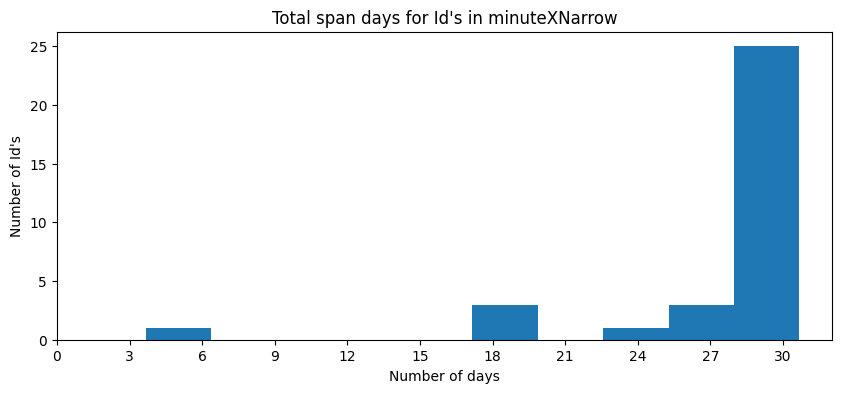

In [87]:
ax = count_calories.set_index('Id').div(60).div(24).plot(figsize = (10,4),\
                                                         use_index = False, \
                                                         title = "Total span days for Id's in minuteXNarrow",\
                                                         kind= 'hist',\
                                                         legend= False,
                                                         xticks = np.arange(0,33,3, dtype = 'int'))
ax.set_xlabel('Number of days')
ax.set_ylabel("Number of Id's")

Abajo podemos ver la cantidad exacta de días representados pars cada id (los datos están transpuestos para ahorrar espacio de visualización). El mínimo es 3.6 días. Decidimos trabajar con los datos que cuyo intervalo de tiempo alcance a representar 25 días.

In [94]:
count_calories.set_index('Id').div(24).div(60).T.sort_values(by = 0, axis='columns', ascending = False)

Id,1927972279,2026352035,2873212765,4558609924,1624580081,4388161847,8053475328,2022484408,2320127002,8877689391,...,3977333714,8792009665,6290855005,6117666160,6775888955,7007744171,3372868164,8253242879,2347167796,4057192912
0,30.666667,30.666667,30.666667,30.666667,30.666667,30.625,30.625,30.625,30.625,30.583333,...,29.0,28.0,27.708333,27.5,25.416667,25.041667,19.666667,17.958333,17.25,3.666667


In [99]:
ids_25days = count_calories['Id'][count_calories.iloc[:,1].div(60).div(24) > 25] #Filter 29 id's of 33
# renaming
calories = all_df['minuteCaloriesNarrow_merged']
intensities = all_df['minuteIntensitiesNarrow_merged']
MET = all_df['minuteMETsNarrow_merged']
steps = all_df['minuteStepsNarrow_merged']

# Just conserve id's with at least 25 days of records
calories = calories.loc[calories['Id'].isin(ids_25days)]
intensities = intensities.loc[intensities['Id'].isin(ids_25days)]
MET = MET.loc[MET['Id'].isin(ids_25days)]
steps = steps.loc[steps['Id'].isin(ids_25days)]


Ahora verifiquemos que el span de tiempo sea continuo. 
Hya dos maneras de hacerlo, ver si hay huecos en la gráfica.

In [ ]:
# We convert ActivityMinute to datetime. Calories already converted. We also create a Day
# calories['datetime'] = pd.to_datetime( calories.pop('ActivityMinute'), \
#                                           format = '%m/%d/%Y %I:%M:%S %p' )

intensities['datetime'] = pd.to_datetime( intensities.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
intensities['Day_and_hour'] = intensities['datetime'].dt.strftime('%Y-%m-%d %H')

MET['datetime'] = pd.to_datetime( MET.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
MET['Day_and_hour'] = MET['datetime'].dt.strftime('%Y-%m-%d %H')

steps['datetime'] = pd.to_datetime( steps.pop('ActivityMinute'), \
                                    format = '%m/%d/%Y %I:%M:%S %p' )
steps['Day_and_hour'] = steps['datetime'].dt.strftime('%Y-%m-%d %H')


Ahora exploremos los rangos mínimos y máximos de períodos. 
Podemos ver que todos empiezan en la misma fecha: 12-04-2016. Aquí están ordenados de los que llegan del período más largo al más corto. Aquí tenemos tres opciones nos quedamos con los que tienen el mes completo. del 12 al 12. O nos quedamos con registros completos hasta 7 a media noche. O simplemente conservamos la información tal cual está. Ahora cambiamos de opinión y decidimos optar por 

Una exploración nos confirma que los rangos son iguales para todas las categorías: Calorías, intensidades, MET y steps. Además como la cantidad de registros es igual para todos podemos estar segurpos de que contienen las mismas series de tiempo por Id.

In [176]:
# Exploremos los rangos minimos y maximos de fechas.
max_min_dates_table = calories.groupby('Id').agg(min_date = ('datetime', 'min'),
                           max_date = ('datetime', 'max')).loc[ids_25days]
max_min_dates_table

,min_date,max_date
Id,,
1927972279,2016-04-12,2016-05-12 15:59:00
2026352035,2016-04-12,2016-05-12 15:59:00
2873212765,2016-04-12,2016-05-12 15:59:00
4558609924,2016-04-12,2016-05-12 15:59:00
1624580081,2016-04-12,2016-05-12 15:59:00
4388161847,2016-04-12,2016-05-12 14:59:00
8053475328,2016-04-12,2016-05-12 14:59:00
2022484408,2016-04-12,2016-05-12 14:59:00
2320127002,2016-04-12,2016-05-12 14:59:00


Note que la primera fecha es 2016-04-12 00:00:00 y que las últimas fechas suelen ser hasta las 15:59:00 del 2016-05-12 por lo que el 11 de mayo es el último día completo. Por lo tanto, decidimos reducir solo a aquellas ids y fechas que estén en ese rango.

In [184]:
from datetime import datetime
limit_date = datetime.strptime('2016-05-11 23:59:01', '%Y-%m-%d %H:%M:%S')

ids_full_month = max_min_dates_table[max_min_dates_table['max_date'] >= limit_date].index

#Just id's with full month
calories = calories.loc[calories['Id'].isin(ids_full_month)]
intensities = intensities.loc[intensities['Id'].isin(ids_full_month)]
MET = MET.loc[MET['Id'].isin(ids_full_month)]
steps = steps.loc[steps['Id'].isin(ids_full_month)]

# Now, delete extra records.
calories = calories.loc[calories['datetime']<limit_date]
intensities = intensities.loc[intensities['datetime']<limit_date]
MET = MET.loc[MET['datetime']<limit_date]
steps = steps.loc[steps['datetime']<limit_date]


Ahora buscaremos por patrones generales dentro de los datos. La gráfica de abajo es una indicación de que hay una clara diferencia entre usuarios regulares e irregulares. Encontramos que los siguientes Id's tienen comportamientos marcadamente diferentes: 

1844505072, 1927972279 , 4020332650.

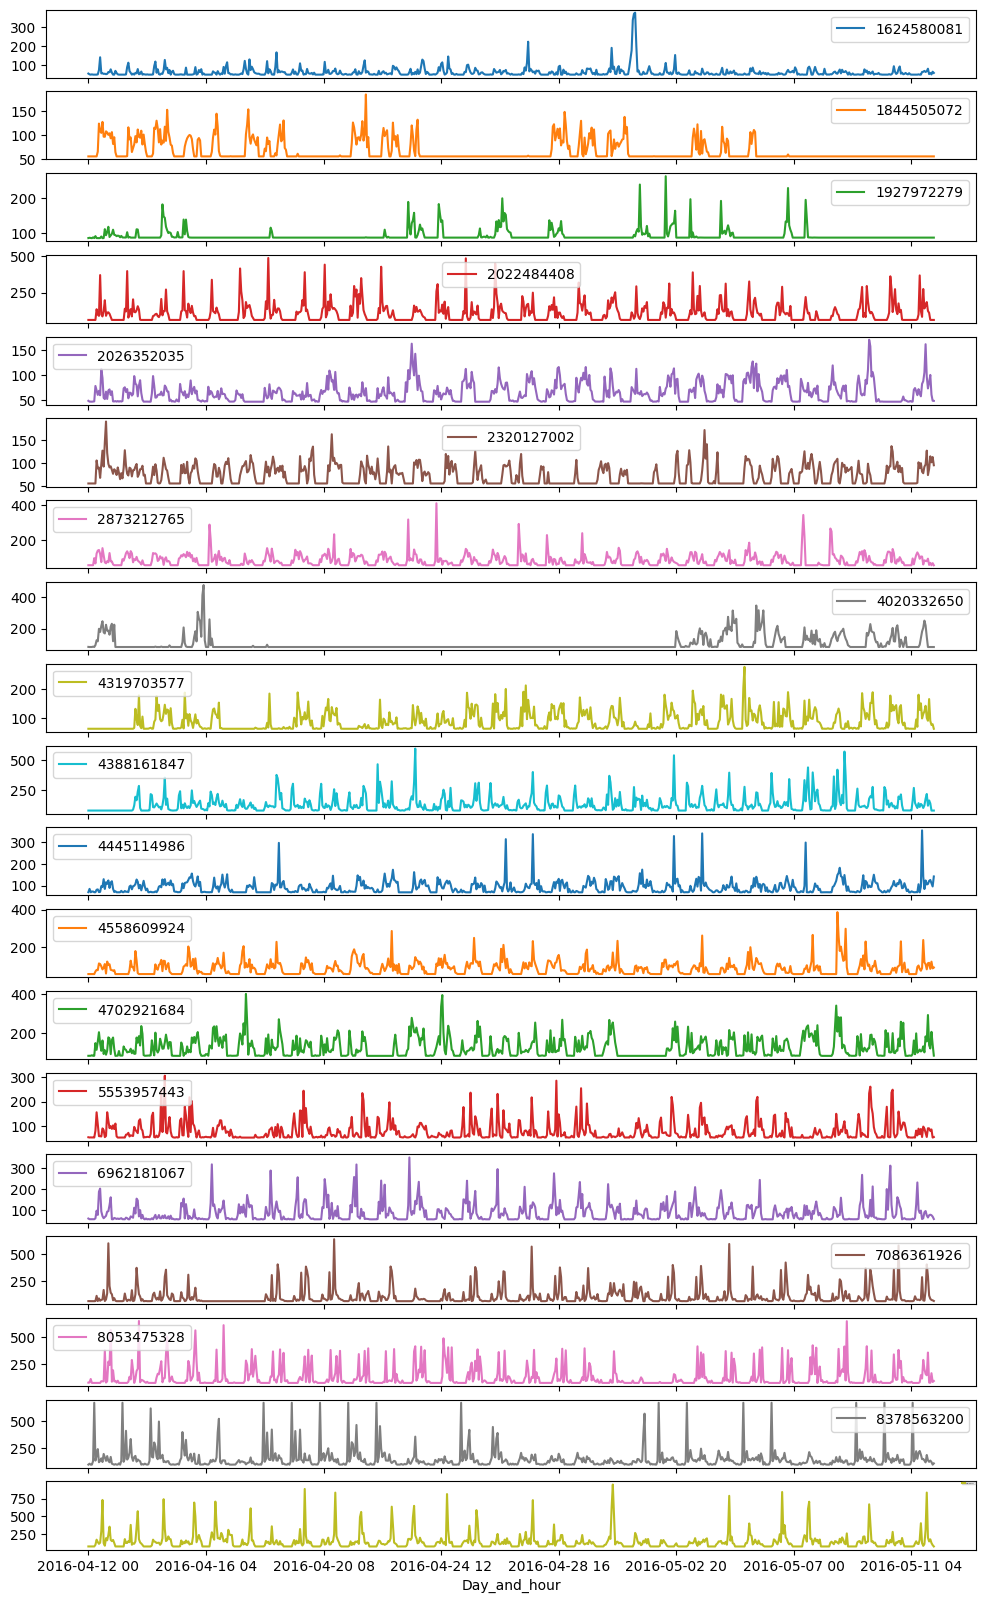

In [199]:
table_cal = calories.pivot_table('Calories', index = 'Day_and_hour', columns = 'Id', aggfunc = sum )
table_cal.plot(figsize = (12,20) , subplots = True, legend = True, sharex = True)


De nuevo vemos diferentes comportamientos para los mismo 3 id's. 

array([<AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>], dtype=object)

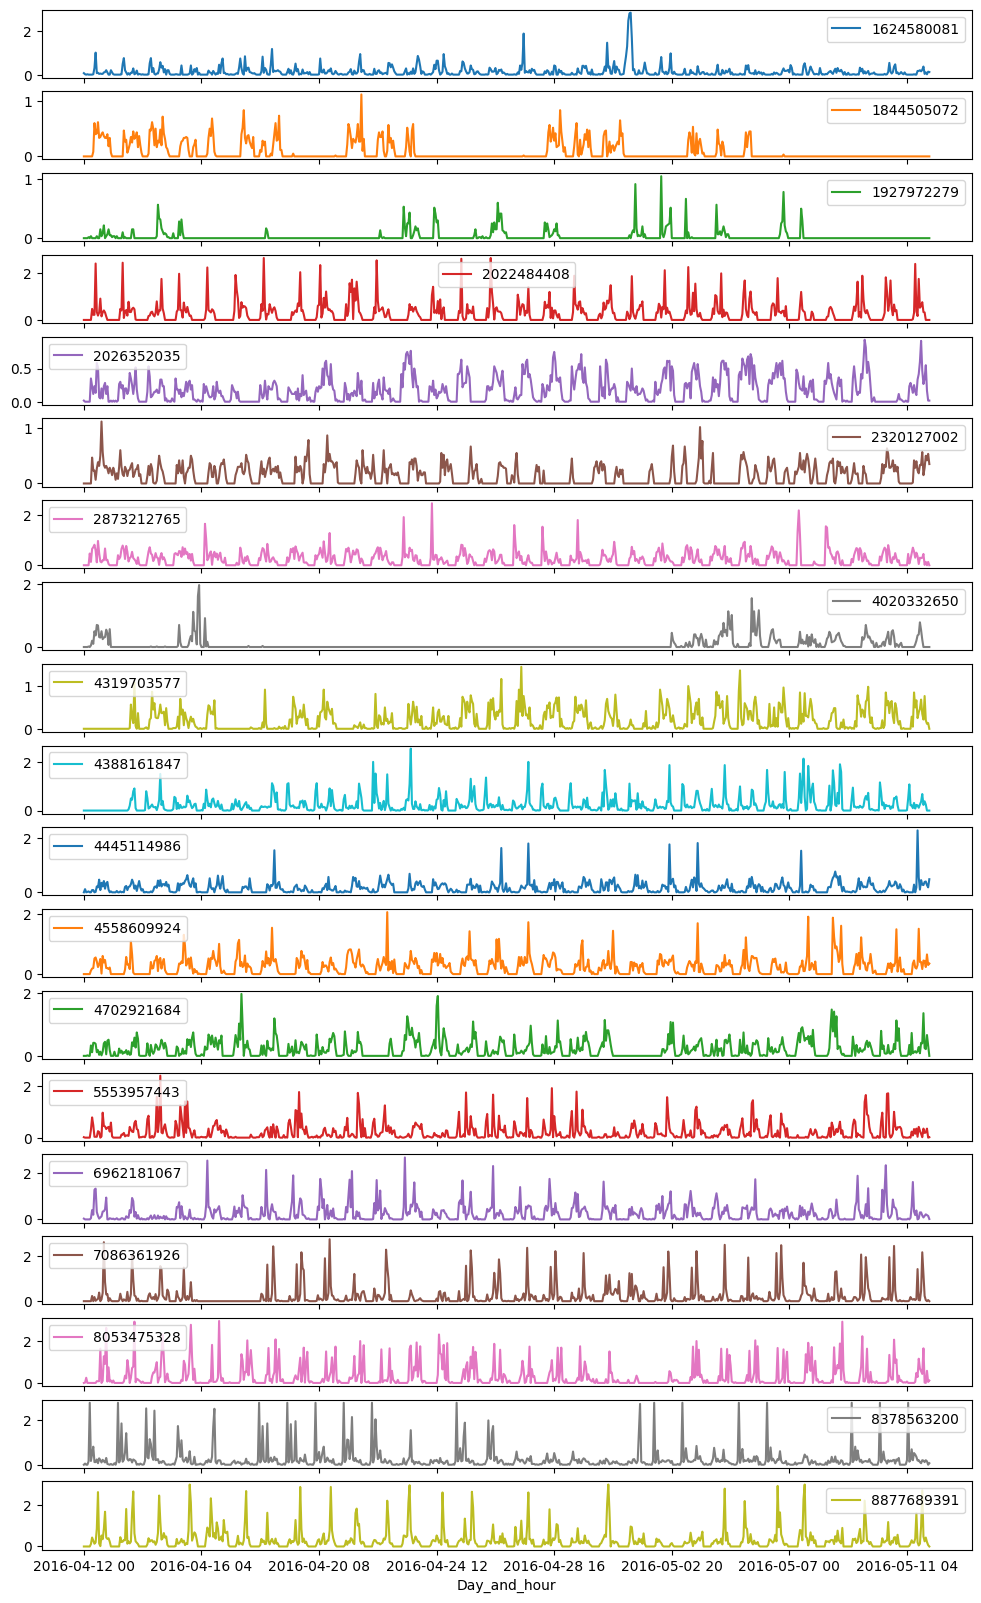

In [205]:
table_int = intensities.pivot_table('Intensity', index = 'Day_and_hour', columns = 'Id', aggfunc = 'mean' )
table_int.plot(figsize = (12,20) , subplots = True, legend = True, sharex = True)


array([<AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>], dtype=object)

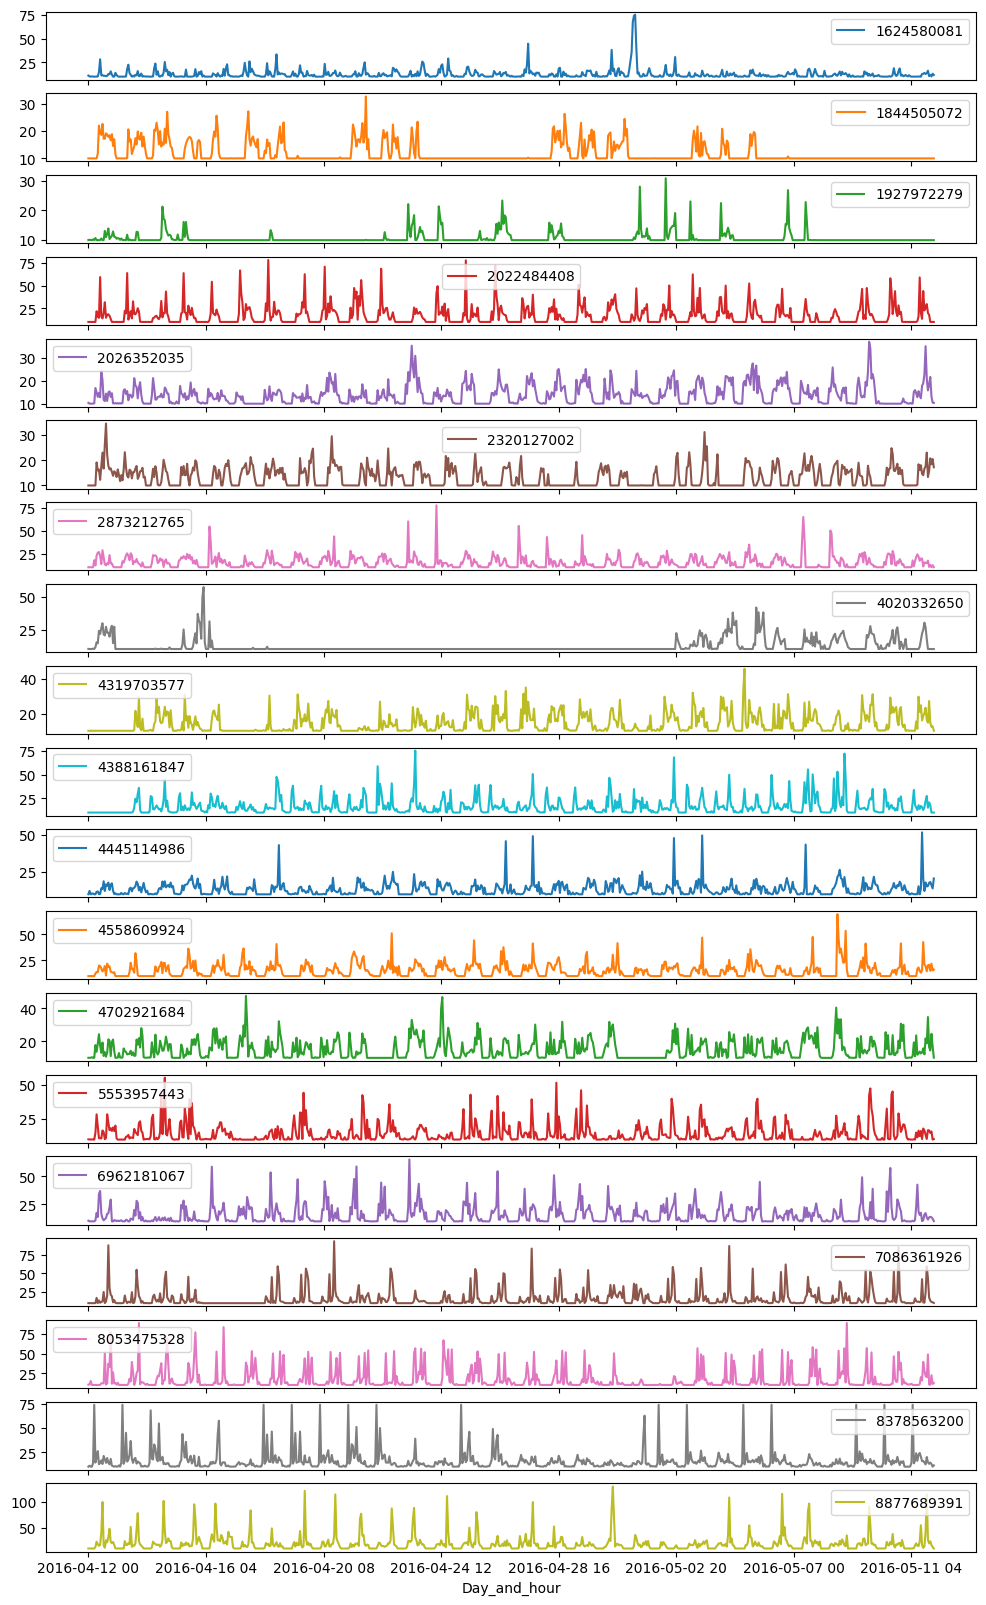

In [207]:
table_MET = MET.pivot_table('METs', index = 'Day_and_hour', columns = 'Id', aggfunc = 'mean' )
table_MET.plot(figsize = (12,20) , subplots = True, legend = True, sharex = True)

array([<AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>,
       <AxesSubplot:xlabel='Day_and_hour'>], dtype=object)

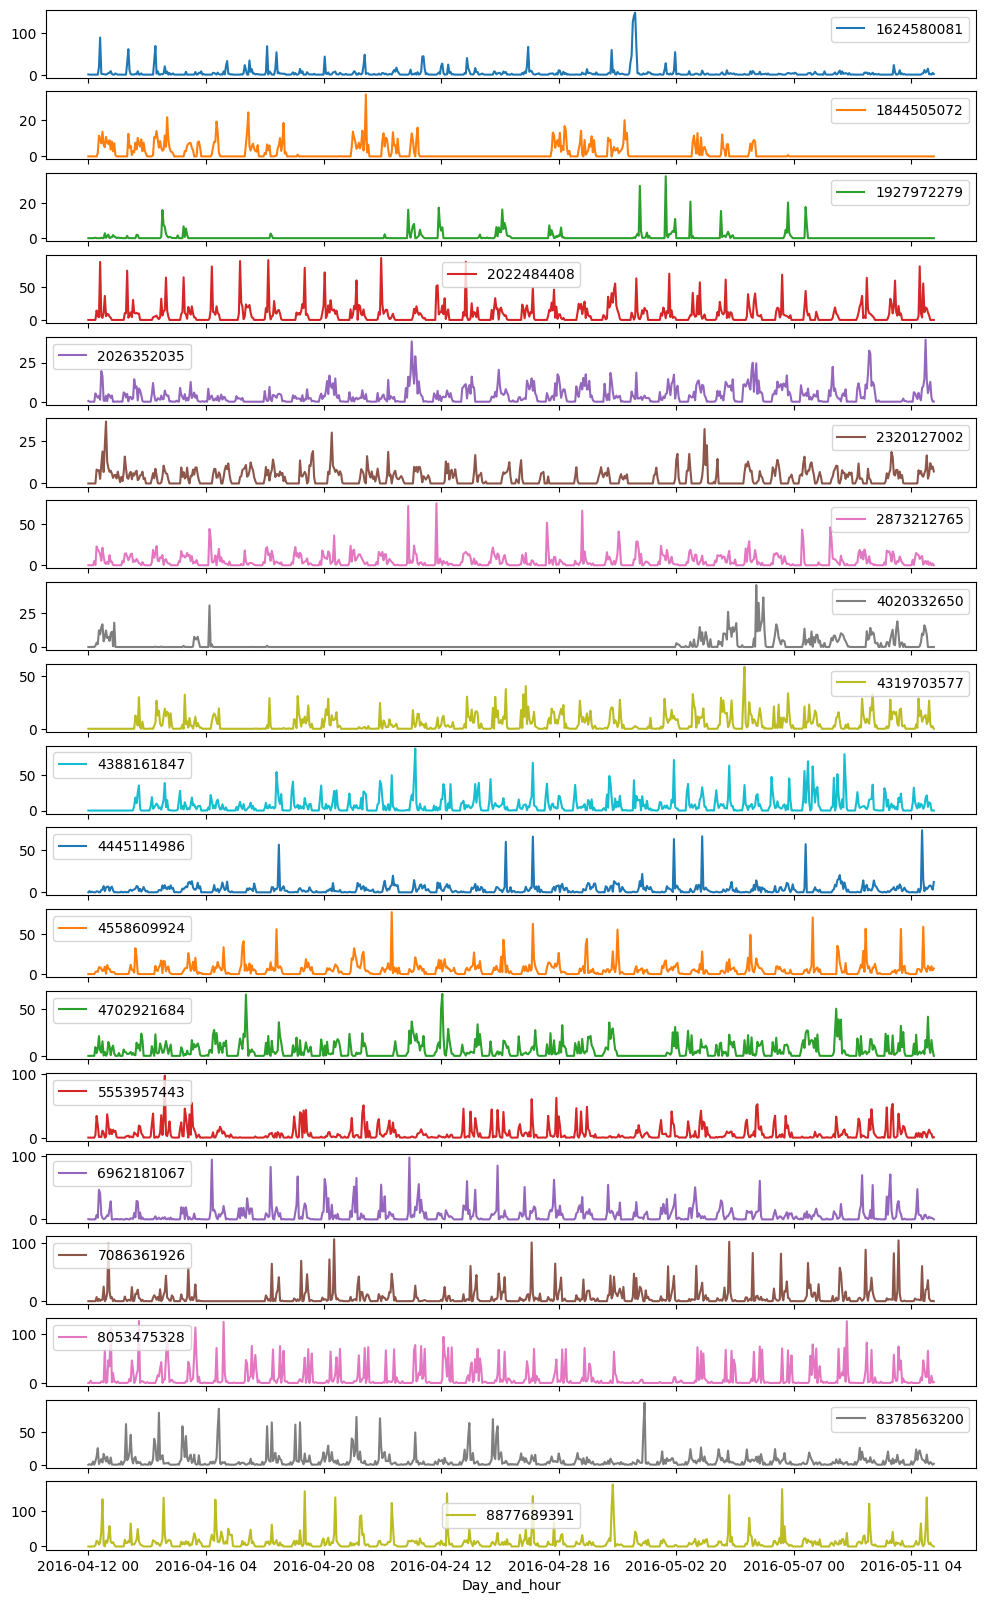

In [209]:
table_steps = steps.pivot_table('Steps', index = 'Day_and_hour', columns = 'Id', aggfunc = 'mean' )
table_steps.plot(figsize = (12,20) , subplots = True, legend = True, sharex = True)

## Apéndice
### A.1 carga de datasets y exploración de tablas

In [6]:
import os
import glob

path = r'C:\Users\diego\Desktop\Books_and_courses\Google_Data_Analysis_Prof_Certificate'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))# advisable to use os.path.join as this makes concatenation OS independent
# Leemos todos los dataframes
li = []
for f in all_files:
    df = pd.read_csv(f)
    li.append(df)
    
# Obtenemos los nombres de todos los archivos csv en este directorio
all_files = os.listdir('C:\\Users\\diego\\Desktop\\Books_and_courses\\Google_Data_Analysis_Prof_Certificate')    
csv_names = list(filter(lambda f: f.endswith('.csv'), all_files))
csv_names = [csv_names[i].replace('.csv', '') for i in range(len(csv_names))]

all_df = pd.Series(li, index = csv_names) # Series con todos los dataframes, indexados por sus nombres.

In [48]:
for df in all_df:
    print( df.info(), df.name , '\n ------*-----\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

**Notas**
Se puede ver por la información anterior que los datos están separados como tablas relacionales. Algunas tablas sirven de apoyo a otras con información detallada de tiempo en distinta granularidad: diaria, por hora y por minutos. Aparentemente, los datos en _minutosXwide_ y _minutesXnarrow_ solo se diferencian en que una tabla contiene los datos en formato Wide y la otra en formato Long. Se puede decir que hay 4 categorías en las que los datos se encuentran más o menos completos:

* Intensidades
* Calorías
* Pasos
* Sueño

Otras carecterísticas con menor información son: Ritmo cardíaco, MET y peso. Particularmente peso tiene una considerbale cantidad de valores faltantes.

### A.2 Diferencias entre wide y narrow minutes data

In [7]:
# De algunos Id's hay mas registros y de otros menos. 
differences = (60*all_df['minuteCaloriesWide_merged']['Id'].value_counts()).sort_index() \
                - all_df['minuteCaloriesNarrow_merged']['Id'].value_counts().sort_index() #A grandes rasgos hay más datos en Narrow
differences

1503960366     120
1624580081    -420
1644430081   -1440
1844505072    -420
1927972279    -420
2022484408    -360
2026352035    -420
2320127002    -360
2347167796   -1440
2873212765    -660
3372868164   -1440
3977333714    1740
4020332650    -360
4057192912   -1440
4319703577   -1440
4388161847   -1200
4445114986    -360
4558609924   -1140
4702921684    -300
5553957443   -1440
5577150313   -1440
6117666160   -1440
6290855005   -1440
6775888955   -1440
6962181067    -240
7007744171   -1440
7086361926    -780
8053475328    -420
8253242879   -1440
8378563200    -360
8583815059   -1440
8792009665   -1440
8877689391    -360
Name: Id, dtype: int64

In [8]:
differences.value_counts() #At least there is a pattern between id's

-1440    14
-360      6
-420      5
 120      1
-660      1
 1740     1
-1200     1
-1140     1
-300      1
-240      1
-780      1
Name: Id, dtype: int64

In [177]:
# Por exploración sabemos que ambos conjuntos tienen los mismos id's. 
# La diferencia de registros se debe a la diferencia de rangos de fechas en cada dataset.

mins_wide = []
max_wide = []

mins_long = []
max_long = []
for id_number in all_df['minuteCaloriesNarrow_merged']['Id'].unique():
    bool_long = all_df['minuteCaloriesNarrow_merged']['Id'] == id_number 
    bool_wide =  all_df['minuteCaloriesWide_merged']['Id'] == id_number     

    long_data = all_df['minuteCaloriesNarrow_merged'].loc[bool_long, 'ActivityMinute']
    wide_data =  all_df['minuteCaloriesWide_merged'].loc[bool_wide, 'ActivityHour']

    long_data['dates'] =  pd.to_datetime(long_data, format = '%m/%d/%Y %I:%M:%S %p' )
    wide_data['dates'] =  pd.to_datetime(wide_data, format = '%m/%d/%Y %I:%M:%S %p' )
    
    print(id_number)
    print('WIDE', 'min:', min(wide_data['dates']) ,'MAX:', max(wide_data['dates']) )
    print('LONG:','min:' , min(long_data['dates']), 'MAX:' , max(long_data['dates']), '\n')
    mins_wide.append(min(wide_data['dates']))
    mins_long.append(min(long_data['dates']))
    max_wide.append(max(wide_data['dates']))
    max_long.append(max(long_data['dates']))
    



1503960366
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-12 22:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 20:59:00 

1624580081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

1644430081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-11 11:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 11:59:00 

1844505072
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 03:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 10:59:00 

1927972279
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2022484408
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

2026352035
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2320127002
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

23471677

Con la gráfica de abajo resulta evidente que las diferencias en cantidad de registros en Calorías para Wide y narrow minutes se deben a que los datos pertenecen a rangos diferentes. Como regla general los datos de Calorías en Narrow (i.e. Long) empiezan un día antes (2016-04-12) que los datos en Wide (2016-04-13). Sin embargo, la mayor diferencia en registros se debe a los rangos máximos. En la mayoría de los casos Wide tiene una fecha mayor que long. En otros casos coinciden. No hay un rango de fechas largo que garantize que se contendrían ambos registros. De manera que no es compatible usar tanto Wide como Long. Lo recomendable es hacer una elección

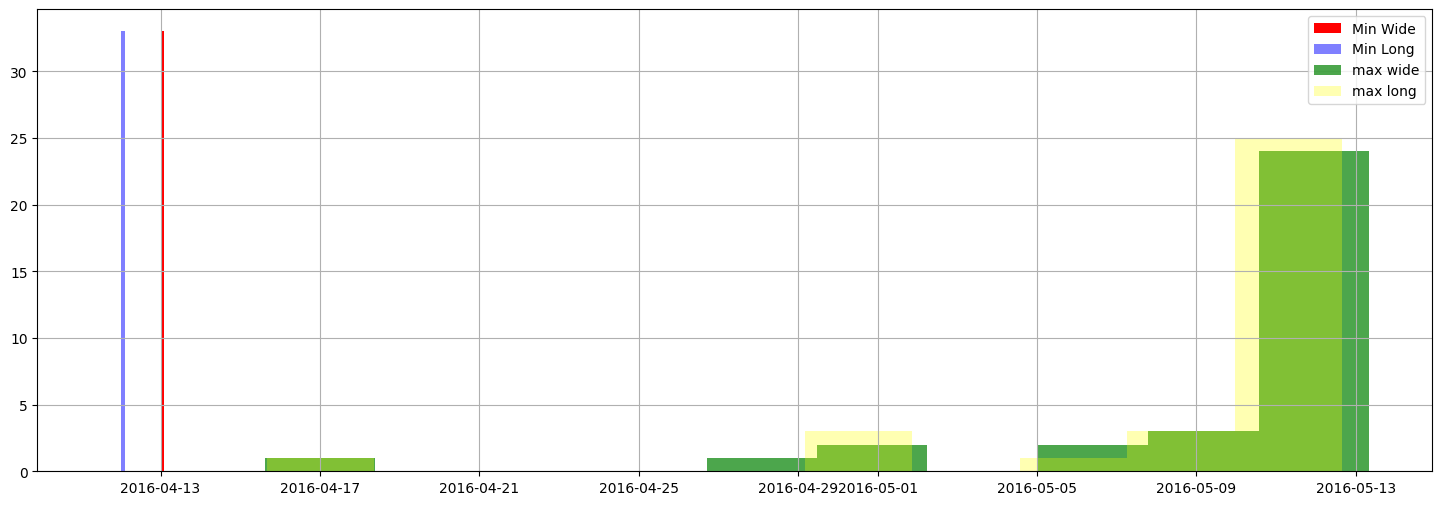

In [201]:
fig = plt.figure(figsize = (18,6))

pd.Series(mins_wide).hist(color = 'red', alpha = 1, label = 'Min Wide')
pd.Series(mins_long).hist(color = 'blue', alpha = 0.5 , label = 'Min Long')
pd.Series(max_wide).hist(color = 'green', alpha = 0.7, label = 'max wide')
pd.Series(max_long).hist(color = 'yellow', alpha = 0.3, label = 'max long')

plt.legend()

### A.3 Elección de minutes de acuerdo a consistencia con Hourly, Daily

Sabemos que los datos tienen una estructura jerárquica. Están agrupados por minutos -> Horas -> Días.

* ¿Los datos por horas representan los promedios cada 60 minutos? r:// No, son la suma de minutes Narrow
* ¿Acaso los datos por horas coinciden con los datos en long o en narrow format? r:// Narrow
* ¿Y los datos diarios sí coinciden con alguna agregación de los datos por horas? r://

In [9]:
all_df['hourlyCalories_merged']['datetime'] = pd.to_datetime( all_df['hourlyCalories_merged'].pop('ActivityHour'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
all_df['hourlyCalories_merged']

,Id,Calories,datetime
0,1503960366,81,2016-04-12 00:00:00
1,1503960366,61,2016-04-12 01:00:00
2,1503960366,59,2016-04-12 02:00:00
3,1503960366,47,2016-04-12 03:00:00
4,1503960366,48,2016-04-12 04:00:00
...,...,...,...
22094,8877689391,126,2016-05-12 10:00:00
22095,8877689391,192,2016-05-12 11:00:00
22096,8877689391,321,2016-05-12 12:00:00
22097,8877689391,101,2016-05-12 13:00:00


Se usó **Narrow** minutes para agregar los datos. Long format es más adecuado para realizar calculos y además tiene más observaciones. Se identificó que los datos agrupados por horas representan la suma total de las calorías en minutos Narrow. 

In [10]:
all_df['minuteCaloriesNarrow_merged']['datetime'] = pd.to_datetime(all_df['minuteCaloriesNarrow_merged'].pop('ActivityMinute'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
all_df['minuteCaloriesNarrow_merged'].head()

,Id,Calories,datetime
0,1503960366,0.7865,2016-04-12 00:00:00
1,1503960366,0.7865,2016-04-12 00:01:00
2,1503960366,0.7865,2016-04-12 00:02:00
3,1503960366,0.7865,2016-04-12 00:03:00
4,1503960366,0.7865,2016-04-12 00:04:00


In [11]:
all_df['minuteCaloriesNarrow_merged']['Day_and_hour'] = all_df['minuteCaloriesNarrow_merged']['datetime'].dt.strftime('%Y-%m-%d %H')
all_df['minuteCaloriesNarrow_merged'].groupby(['Id','Day_and_hour'])['Calories'].sum()

Id          Day_and_hour 
1503960366  2016-04-12 00     81.324098
            2016-04-12 01     60.560498
            2016-04-12 02     58.830198
            2016-04-12 03     47.189999
            2016-04-12 04     47.504599
                                ...    
8877689391  2016-05-12 09     88.134207
            2016-05-12 10    126.079197
            2016-05-12 11    192.270776
            2016-05-12 12    320.774579
            2016-05-12 13    101.469507
Name: Calories, Length: 22093, dtype: float64

In [12]:
all_df['minuteCaloriesWide_merged']['ActivityHour'] = pd.to_datetime(all_df['minuteCaloriesWide_merged']['ActivityHour'], \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
values = all_df['minuteCaloriesWide_merged'].iloc[:, 2:].apply('sum', axis = 'columns')
values.index = all_df['minuteCaloriesWide_merged'][['Id','ActivityHour']]

In [13]:
values

(1503960366, 2016-04-13 00:00:00)     68.740098
(1503960366, 2016-04-13 01:00:00)     48.133799
(1503960366, 2016-04-13 02:00:00)     47.189999
(1503960366, 2016-04-13 03:00:00)     52.695498
(1503960366, 2016-04-13 04:00:00)     47.347299
                                        ...    
(8877689391, 2016-05-13 03:00:00)     73.020000
(8877689391, 2016-05-13 04:00:00)     73.020000
(8877689391, 2016-05-13 05:00:00)     73.020000
(8877689391, 2016-05-13 06:00:00)     99.307200
(8877689391, 2016-05-13 07:00:00)    164.173302
Length: 21645, dtype: float64

Veamos ahora los datos diarios

In [14]:
all_df['dailyCalories_merged']['datetime'] = pd.to_datetime(all_df['dailyCalories_merged'].pop('ActivityDay'))
all_df['dailyCalories_merged']

,Id,Calories,datetime
0,1503960366,1985,2016-04-12
1,1503960366,1797,2016-04-13
2,1503960366,1776,2016-04-14
3,1503960366,1745,2016-04-15
4,1503960366,1863,2016-04-16
...,...,...,...
935,8877689391,2847,2016-05-08
936,8877689391,3710,2016-05-09
937,8877689391,2832,2016-05-10
938,8877689391,3832,2016-05-11


Aunque los valores son cercanos, notamos algunas inconsistencias significativas. Posiblemente se deba a que la agregación en Hourly se hizo redondeando cifras.

In [15]:
all_df['hourlyCalories_merged']['date'] = all_df['hourlyCalories_merged']['datetime'].dt.date
all_df['hourlyCalories_merged'].groupby(['Id','date'])['Calories'].sum()

Id          date      
1503960366  2016-04-12    1988
            2016-04-13    1798
            2016-04-14    1776
            2016-04-15    1745
            2016-04-16    1866
                          ... 
8877689391  2016-05-08    2840
            2016-05-09    3695
            2016-05-10    2826
            2016-05-11    3827
            2016-05-12    1771
Name: Calories, Length: 934, dtype: int64

In [16]:
# Finalmente vemors dailyActivity que parece ser el dataset más grande
all_df['dailyActivity_merged'].head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


**Notas**: De acuerdo a lo anterior podemos suponer que los datos se corresponden con los encontrados en Narrow minutes. 
Las demás tablas se construyeron como agregaciones de Narrow minutes. Encontramos pequeñas inconsistencias en dichas agregaciones,
posiblemente debido a aproximaciones. En DailyActivity encontramos el merge de todos los datos.